In [2]:
####################### importing libraries #########################

import numpy as np 
import os 
import shutil 
from glob import glob
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt 

import torch 
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

from sklearn.model_selection import train_test_split

import mlflow

In [ ]:
import torch 

from torch.optim import Ada

In [2]:
########## device agnostic #########

device = "cuda" if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
######################### Loading Data ######################

train_dir = './data/training_set/'
test_dir = './data/test_set/'

train_cat_dir = os.path.join(train_dir, 'cats')
train_dog_dir = os.path.join(train_dir,'dogs')

def create_directories():
    try:
        if Path(train_cat_dir).is_dir() and Path(train_dog_dir).is_dir():
            print('dir already exist')
        else:
            os.makedirs(train_cat_dir,exist_ok= True)
            os.makedirs(train_dog_dir, exist_ok = True)
            
    except:
       pass


def move_to_respective_directories(
    source_folder, 
    destination_folder, 
    keyword
    ):
    for image_file_path in glob(os.path.join(source_folder, '**')):
        try:
            image_file_name = os.path.basename(image_file_path)
            if keyword in image_file_name:
                shutil.move(
                    os.path.join(source_folder, image_file_name), 
                    os.path.join(destination_folder, image_file_name)
                    )
        except Exception as e:
            print(e)


create_directories()

move_to_respective_directories(train_dir, train_cat_dir, 'cats')
move_to_respective_directories(train_dir, train_dog_dir, 'dogs')



dir already exist
Cannot move a directory './data/training_set/cats' into itself './data/training_set/cats\cats'.
Cannot move a directory './data/training_set/dogs' into itself './data/training_set/dogs\dogs'.


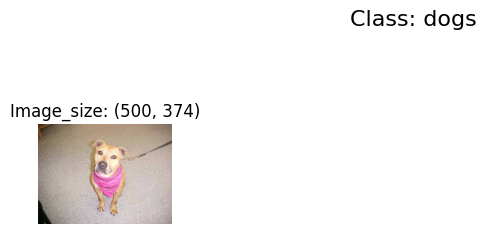

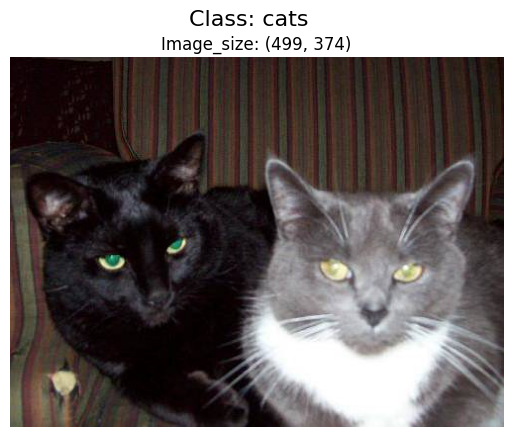

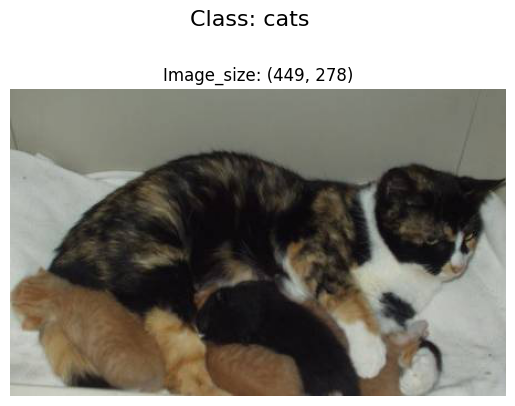

In [4]:
########## visualize the sample data ###########
import random 

random.seed(42)
image_path_list = list(Path(train_dir).glob("*/*.jpg"))

random_img_path = random.sample(image_path_list, k = 3)

fig = plt.figure(figsize=(10,6))
for idx in range(len(random_img_path)):
    with Image.open(random_img_path[idx]) as f:
        class_name = random_img_path[idx].parent.stem
        fig.add_subplot(2,5,idx+1)
        plt.imshow(f)
        plt.title(f"Image_size: {f.size}")
        plt.axis('off')
        plt.suptitle(f"Class: {class_name}", fontsize = 16)
        plt.show()


In [5]:
from typing import Tuple, List, Dict

In [6]:
# Make a func to find classes in target dir 

def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:

    # 1. get a class name by scanning the target dir 
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names not found 
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
    
    # 3. Create a dict of index labels (computers prefers numbers rather than string labels)

    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

    return classes, class_to_idx

In [7]:
########## CustomImageFolder class ############

# 1. subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):

    # 2. Initialize with target_dir and transform (optional) parameter
    def __init__(self, target_dir: str, transform = None) -> None:

        # 3. create class attributes
        self.path = list(Path(target_dir).glob("*/*.jpg"))

        # 4. setup transform
        self.transform = transform

        # create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(target_dir)

    # 4. Make function to load images 
    def load_images(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it"
        image_path = self.path[index]

        return Image.open(image_path)
    
    # 5. Overwrite the __len__() method (optional but recommended for subclasses torch.utils.data.Dataset)

    def __len__(self) -> int:
        "Returns the total num of samples"
        return len(self.path)
    
    # 6. Overwrite the __getitem__() method (required)
    def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (x, y)"

        img = self.load_images(index)
        class_name = self.path[index].parent.name
        class_idx = self.class_to_idx[class_name]

        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx


In [8]:
from torchvision.transforms import v2

In [9]:
######### augment the train data ##########

train_transform = v2.Compose([
    v2.Resize(size = (64, 64)),
    v2.RandomHorizontalFlip(p = 0.5),
    v2.ToTensor()
])

test_transform = v2.Compose([
    v2.Resize((64, 64)),
    v2.ToTensor()
])

d:\miniconda3\envs\torch\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [10]:
train_data_custom = ImageFolderCustom(target_dir = train_dir,
                               transform = train_transform)

test_data_custom = ImageFolderCustom(target_dir= test_dir, 
                                    transform= test_transform)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x2426384bc80>,
 <__main__.ImageFolderCustom at 0x24263849a00>)

In [11]:
len(train_data_custom), len(test_data_custom)

(8005, 2023)

In [12]:
print(f"classes: {train_data_custom.classes}\n\nclasses_with_index: {train_data_custom.class_to_idx}")

classes: ['cats', 'dogs']

classes_with_index: {'cats': 0, 'dogs': 1}


In [13]:
# sample image array
train_data_custom[0][0]

tensor([[[0.7608, 0.5059, 0.3137,  ..., 0.1686, 0.1686, 0.1529],
         [0.7647, 0.4941, 0.3216,  ..., 0.1725, 0.1490, 0.1451],
         [0.7882, 0.5020, 0.3294,  ..., 0.1804, 0.1412, 0.1451],
         ...,
         [0.2941, 0.3020, 0.2745,  ..., 0.0902, 0.0863, 0.0902],
         [0.2627, 0.2706, 0.2314,  ..., 0.0863, 0.0824, 0.0824],
         [0.1843, 0.2588, 0.3020,  ..., 0.0902, 0.0902, 0.0980]],

        [[0.7490, 0.5137, 0.3451,  ..., 0.1843, 0.1804, 0.1686],
         [0.7412, 0.5020, 0.3569,  ..., 0.1882, 0.1608, 0.1608],
         [0.7451, 0.5098, 0.3686,  ..., 0.1961, 0.1529, 0.1608],
         ...,
         [0.2353, 0.2392, 0.2235,  ..., 0.0902, 0.0863, 0.0902],
         [0.2078, 0.2039, 0.1647,  ..., 0.0824, 0.0784, 0.0784],
         [0.1333, 0.1961, 0.2353,  ..., 0.0824, 0.0824, 0.0902]],

        [[0.6431, 0.5098, 0.4314,  ..., 0.1922, 0.2039, 0.1647],
         [0.6510, 0.5098, 0.4431,  ..., 0.1961, 0.1843, 0.1608],
         [0.6431, 0.5020, 0.4392,  ..., 0.2039, 0.1765, 0.

In [14]:
# sample image label 0 -> cat , 1-> dog
train_data_custom[0][1]

0

In [15]:
##### Turn custom images in dataloader 

workers = os.cpu_count()

train_dataloader = DataLoader(
    dataset= train_data_custom,
    batch_size = 16,
    num_workers = 0,
    shuffle = True
)

test_dataloader = DataLoader(
    dataset = test_data_custom,
    batch_size = 4, 
    num_workers = 0,
    shuffle = False
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x2426384a4e0>,
 <torch.utils.data.dataloader.DataLoader at 0x2426a6c8560>)

In [16]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader))

# Batch size will now be 16, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([16, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([16])


In [17]:
############# create a TinyVGG model class ###########

class VGG16(nn.Module):
    def __init__(self, input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
        super(VGG16, self).__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels= input_shape,
                      out_channels= hidden_units,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels= hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                padding=1,
                stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.conv_block_2 =nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels= hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),

            nn.ReLU(),
            nn.MaxPool2d(kernel_size= 2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features= hidden_units*16*16,
                      out_features= output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)

        return x

In [1]:
"Custom ResNet-18 architecture"

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels,
                               kernel_size = 3, stride= stride, padding =1, bias = False)
        
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLu(inplace = True)

        self.conv2 = nn.Conv2d(in_channels= out_channels, out_channels= out_channels,
                               kernel_size= 3, stride= 1, padding= 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride !=1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels= in_channels, out_channels= out_channels,
                          kernel_size= 1, stride = stride, bias = False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)

        return out
    
class ResNet_18(nn.Module):
    def __init__(self, num_classes = 10):
        super(ResNet_18, self).__init__()

        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size = 3, stride =1 , 
                               padding =1 , bias = False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride = 2, padding= 1)

        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride = 1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride = 2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride = 2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride = 2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []

        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        
        return nn.Sequential(*layers)
    

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = self.view(out.size(0), -1)
        out = self.fc(out)

        return out
    

model_resnet = ResNet_18()

NameError: name 'nn' is not defined

In [18]:
model = VGG16(input_shape = 3, 
              hidden_units = 10, 
              output_shape = len(train_data_custom.classes)).to(device)

from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
VGG16                                    --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       280
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       910
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-6                       910
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       910
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
├─Sequential: 1-3                        --
│    └─Flatten: 2-11                     --
│    └─Linear: 2-12                      5,122
Total params: 8,132
Trainable params: 8,132
Non-trainable params: 0

In [19]:
test_x, test_y = next(iter(train_dataloader))

test_x, test_y = test_x.to(device), test_y.to(device)

y_p = model(test_x)

print("prediction logits:\n", y_p, "\n")

y_prob = torch.softmax(y_p, dim =1)
print("prob of logits:\n",y_prob)

y_class = torch.argmax(y_prob, dim = 1)
print("class of pred:\n", y_class)

print(len(y_p) == len(y_class))

prediction logits:
 tensor([[ 0.0072, -0.0625],
        [ 0.0048, -0.0621],
        [ 0.0031, -0.0591],
        [ 0.0074, -0.0620],
        [ 0.0076, -0.0630],
        [ 0.0088, -0.0611],
        [ 0.0059, -0.0632],
        [ 0.0045, -0.0627],
        [ 0.0055, -0.0596],
        [ 0.0056, -0.0615],
        [ 0.0070, -0.0589],
        [ 0.0085, -0.0585],
        [ 0.0093, -0.0589],
        [ 0.0076, -0.0625],
        [ 0.0073, -0.0603],
        [ 0.0050, -0.0568]], device='cuda:0', grad_fn=<AddmmBackward0>) 

prob of logits:
 tensor([[0.5174, 0.4826],
        [0.5167, 0.4833],
        [0.5155, 0.4845],
        [0.5174, 0.4826],
        [0.5176, 0.4824],
        [0.5175, 0.4825],
        [0.5173, 0.4827],
        [0.5168, 0.4832],
        [0.5163, 0.4837],
        [0.5168, 0.4832],
        [0.5165, 0.4835],
        [0.5167, 0.4833],
        [0.5170, 0.4830],
        [0.5175, 0.4825],
        [0.5169, 0.4831],
        [0.5154, 0.4846]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
class o

In [20]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    
    model.train()
    train_loss, train_acc = 0, 0

    for batch, (x,y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        y_pred = model(x)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim =1), dim = 1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred_class)


    # avg train loss and acc
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc



In [21]:
def test_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module):
    
    model.eval()

    test_loss, test_acc = 0,0

    with torch.inference_mode():
        for batch, (x,y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)

            test_y_pred = model(x)

            loss = loss_fn(test_y_pred, y)
            test_loss += loss

            test_y_pred_class = torch.argmax(torch.softmax(test_y_pred, dim = 1), dim = 1)
            test_acc += (test_y_pred_class == y).sum().item() / len(test_y_pred_class)

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc


In [ ]:
# from tqdm import tqdm 
# start  the timer 
from timeit import default_timer as timer 

def train(model:nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int = 50):
    
    # create an empty results dir
    results = {"train_loss":[],
               "test_loss":[],
               "train_acc":[],
               "test_acc":[]}
    
    # loop for training an testing
    for epoch in range(epochs):
        epoch_start_time = timer()
        train_loss, train_acc = train_step(model = model,
                                           dataloader = train_dataloader,
                                           loss_fn = loss_fn,
                                           optimizer = optimizer)

        test_loss, test_acc = test_step(model = model,
                                        dataloader = test_dataloader,
                                        loss_fn = loss_fn)
        
        epoch_end_time = timer()
        
        print(
            f"epochs: {epoch+1} | train_loss: {train_loss} | train_acc: {train_acc} | test_loss: {test_loss} | test_acc: {test_acc}"
            )
        
        # update the results dictionary
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    return results

In [25]:
######## train and val model ########
    
torch.manual_seed(42)
torch.cuda.manual_seed(42)

num_epochs = 25


model = VGG16(input_shape=3, 
              hidden_units= 10, 
              output_shape= len(train_data_custom.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params= model.parameters(), lr = 0.001)

start_time = timer()

model_results = train(model = model,
                      train_dataloader= train_dataloader,
                      test_dataloader= test_dataloader,
                      loss_fn= loss_fn,
                      optimizer= optimizer,
                      epochs= num_epochs)

end_time = timer()

print(f"total training time: {end_time - start_time:.3f} seconds")


epochs: 1 | train_loss: 0.6881134010360627 | train_acc: 0.5462075848303393 | test_loss: 0.6822252869606018 | test_acc: 0.5640645586297761
epochs: 2 | train_loss: 0.6772978754338628 | train_acc: 0.5790169660678642 | test_loss: 0.6625299453735352 | test_acc: 0.6027667984189723
epochs: 3 | train_loss: 0.6450456316599589 | train_acc: 0.6342065868263473 | test_loss: 0.6301359534263611 | test_acc: 0.6589262187088274
epochs: 4 | train_loss: 0.6037190819452861 | train_acc: 0.6716317365269461 | test_loss: 0.5946003794670105 | test_acc: 0.6905467720685112
epochs: 5 | train_loss: 0.5732928099865447 | train_acc: 0.7033433133732535 | test_loss: 0.607163667678833 | test_acc: 0.6900527009222662
epochs: 6 | train_loss: 0.5554925053419467 | train_acc: 0.7183882235528942 | test_loss: 0.5524243116378784 | test_acc: 0.7088274044795785
epochs: 7 | train_loss: 0.5370493462223731 | train_acc: 0.7288672654690619 | test_loss: 0.5650436282157898 | test_acc: 0.7083333333333334
epochs: 8 | train_loss: 0.527258685

In [37]:
parameters = {"epochs": 25, "loss function": loss_fn.__class__.__name__, "optimizer": optimizer.__class__.__name__, "lr": 0.001 }

In [39]:
import mlflow
mlflow.set_experiment("dogs_cats_classification")
mlflow.set_tracking_uri("127.0.0.1:5000")

OSError: Bad URL: 127.0.0.1|5000

In [3]:
with mlflow.start_run():
    mlflow.log_params(parameters)
    
    # Log model summary.
    with open("model_summary.txt", "w") as f:
        f.write(str(summary(model)))
    mlflow.log_artifact("model_summary.txt")

    mlfow.log_metrics(model_results)

    # Save the trained model to MLflow.
    mlflow.pytorch.log_model(model, "VGG16")



    

NameError: name 'mlflow' is not defined

In [ ]:
import nltk
from nltk.tokenize import word_tokenize

tf = SyllableTokenizer()

a = "hi, how are you?"

token = word_tokenize(a)
print(token)



LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - 'C:\\Users\\nithish.kumar/nltk_data'
    - 'd:\\miniconda3\\envs\\nlp\\nltk_data'
    - 'd:\\miniconda3\\envs\\nlp\\share\\nltk_data'
    - 'd:\\miniconda3\\envs\\nlp\\lib\\nltk_data'
    - 'C:\\Users\\nithish.kumar\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************
